### Team information 🤝
<!-- 👥 -->
<!-- 🤝 -->


| 👤 Name |   E-Mail        |Matriculation no.|
|:----:|:----:|:----:|
| Al-Maamari, Mohammed Ahmed Ali| mohammed.al-maamari@uni-passau.de|108496|
| Otiefy, Yasser | yasser.otiefy@uni-passau.de|107401|


**Things to clearify:**
1. We are a team of two students, so, we might need more words for our solutions (we have to do more companies, and more companies = more words)
2. We answered all the eight tasks of this assignment, including the __bonus__ task.
3. We implemented some plotting functions ourselves to have more flexibility on organizing the plots (color and space flexibility)
4. We ran this notebook in Kaggle.

## Notebook Initialization

In [ ]:
# install necessary packages
!pip install -U git+https://github.com/RalfKellner/aif_course
!pip install stable-baselines3
!pip install sb3-contrib

In [ ]:
from aif_course.aif_environment import TradingEnvironmentNew
from aif_course.aif_analysis import ai_trade_performance
from aif_course.aif_analysis import analyze_actions_taken
from matplotlib import pyplot as plt
from stable_baselines3 import A2C, PPO, DQN, TD3
from IPython.display import clear_output
from sb3_contrib import  ARS, TRPO
import plotly.express as px
import matplotlib as mpl
import matplotlib.style
from tqdm import tqdm
import yfinance as yf
import pandas as pd
import numpy as np
import time

mpl.style.use('ggplot')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Project assignment

Welcome to your project assignment. Your assignment consists of different tasks which are explained below. You can make your assignment alone or within a group up to three people. Note: this semester, the assignment and its tasks are more standardized than in previous semesters. This is why the quantity of each task is multiplied by the number of people of the project assignment, e.g., if an individual is supposed to analyze three companies, two people are supposed to analyze six companies and three people analyze nine companies. This is why I would recommend to hand in individual assignments, you are allowed to discuss the assignment with as many as other people you like. 

Note also, a template for the assignment is given, we only accept assignments using this template, nothing else. Within your assignment, you will choose three companies of your interest, you will train an agent for every company for different time periods with different state variables. The details are explained below for every subtask of your project assignment. An overview of all subtasks is:

1. Choose three companies for your analysis (do not use Apple! It is not permitted for the assignment)
2. Train an agent for each company using the aif_course package and the A2C algorithm from stable baselines 3
3. Choose five technical indicators for reducing state dimensionality and train an agent 
4. Search for state variables by correlation to a target variable and train the agent with these variables
5. Train an agent for one company for different time periods and evaluate the performance for test periods
6. Discuss possible challenges and limitations of the framework used
7. Find one scientific paper with a RL aplication in the area of economics
8. Bonus: compare different algorithms and their performance

Overall, a maximum of 50 points can be collected if you succesfully work through subtasts 1.-7., 5 bonus points can be rewarded for subtask number 8.

**Please hand in your project assignment until September 9, 2022 in notebook format (.ipynb) by uploading it to the folder "Assignments" found in "Files (Dateien)" on the lecture's StudIP page (39910). Please name the file "lastname_matriculationnumber.ipynb"**

## Task 1:
1. Choose three companies for your analysis

We will use yahoo finance as a data source. For instance, if you go to https://www.finance.yahoo.com you can search for a company name and get various information for it. I want you to choose three companies which you find interesting. However, the companies need to exist for at least ten years to have enough data history. If you have the ticker of the company (the capital letters behind the company name in brackets), you can use the yfinance package (which uses the yahoo finance api) to get data for the company. I want you to download data for the past years (at least back until 2012) and give a short presentation of the companies' development over time. Furthermore, please quickly describe why you are interested in these companies and present a few (not more than four), but useful, descriptive statistics to examine overall company performance over the time period (hint: usually, stock price performance is analyzed using log-returns or discrete returns).

### Task 1- Answer:
Here, we will choose the next six companies:
1. Pfizer Inc. (PFE)
2. Amazon.com, Inc. (AMZN)
3. Advanced Micro Devices, Inc. (AMD)
4. Taiwan Semiconductor Manufacturing Company Limited (TSM)
5. Intel Corporation (INTC)
6. JPMorgan Chase & Co. (JPM)

In [ ]:
tickers = ["PFE", "AMZN", "AMD", "TSM", "JPM", "INTC"] # tickers of the companies
ticker2color = {"PFE":"#7DACE3", "AMZN":"#EC901B", "AMD":"#ff4c02", "TSM":"#DA0011", "INTC":"#0068b5", "JPM":"#12325f"} # company colors
ticker2name = {"PFE":"Pfizer", "AMZN":"Amazon", "AMD":"AMD", "TSM":"TSMC", "INTC":"Intel", "JPM":"JPMorgan"} # company names

In [ ]:
def calculate_return(current_closing_price, last_closing_price):
    # calculates the return of a stock 
    return ((current_closing_price - last_closing_price) / last_closing_price)

In [ ]:
def get_company_history(tickers):    
    company_stats = []
    company_history = {}
    for ticker in tickers:
        # Get the company
        cmpny = yf.Ticker(ticker)
        # Get the company info
        cmpny_info = cmpny.info

        # get historical market data
        hist_daily = cmpny.history(period="max", interval='1d')["1990-01-01":]
        hist_weekly = cmpny.history(period="max", interval='1wk')["1990-01-01":]

        # Calculate the return
        hist_weekly["Return"] = hist_weekly[["Open","Close"]].apply(lambda x: calculate_return(x[1],x[0]), axis=1)

        # Mean and standard diviation of the weekly returns: 
        mwr  = round(hist_weekly.Return.mean(),3)
        sdwr = round(hist_weekly.Return.std(),3)

        # Mean and standard diviation of the weekly returns: 
        mwv  = round(hist_weekly.Volume.mean(),3)
        sdwv = round(hist_weekly.Volume.std(),3)


        # Ups:Downs ratio
        weekly_ups   = hist_weekly[hist_weekly["Return"]>0.005].shape[0]
        weekly_downs = hist_weekly[hist_weekly["Return"]<-0.005].shape[0]

        mean_weekly_ups   = round(hist_weekly[hist_weekly["Return"]>0.005]["Return"].mean(), 3)
        mean_weekly_downs = round(hist_weekly[hist_weekly["Return"]<-0.005]["Return"].mean(), 3)
        
        company_history[ticker] = {"hist_weekly":hist_weekly, "hist_daily":hist_daily,}
        company_stats.append({"ticker":ticker, "Mean_weekly_return":mwr, "std_weekly_return":sdwr, 
                 "Mean_weekly_volume":mwv, "std_weekly_volume":sdwv, 
                 "weekly_ups":weekly_ups, "weekly_downs":weekly_downs, 
                 "mean_weekly_ups":mean_weekly_ups, "mean_weekly_downs":mean_weekly_downs})
        
    company_stats_df = pd.DataFrame(data = company_stats)
    return company_history, company_stats_df

# DocString
get_company_history.__doc__ = \
"""Get Company History
Given a list of company tickers, this function returns the history of these companies' stock price, and some descriptive statistics
Args:
    tickers (list of strings): The companies' tickers
    
Returns:
    company_history (dict of pandas.DataFrame): A dictionary of history of the companies stock price [Open, Close, Volume, High, Low, Return]
    company_stats_df (pandas.DataFrame): A pandas dataframe containing descriptive statistics for each company
"""

In [ ]:
company_history, company_stats_df = get_company_history(tickers)

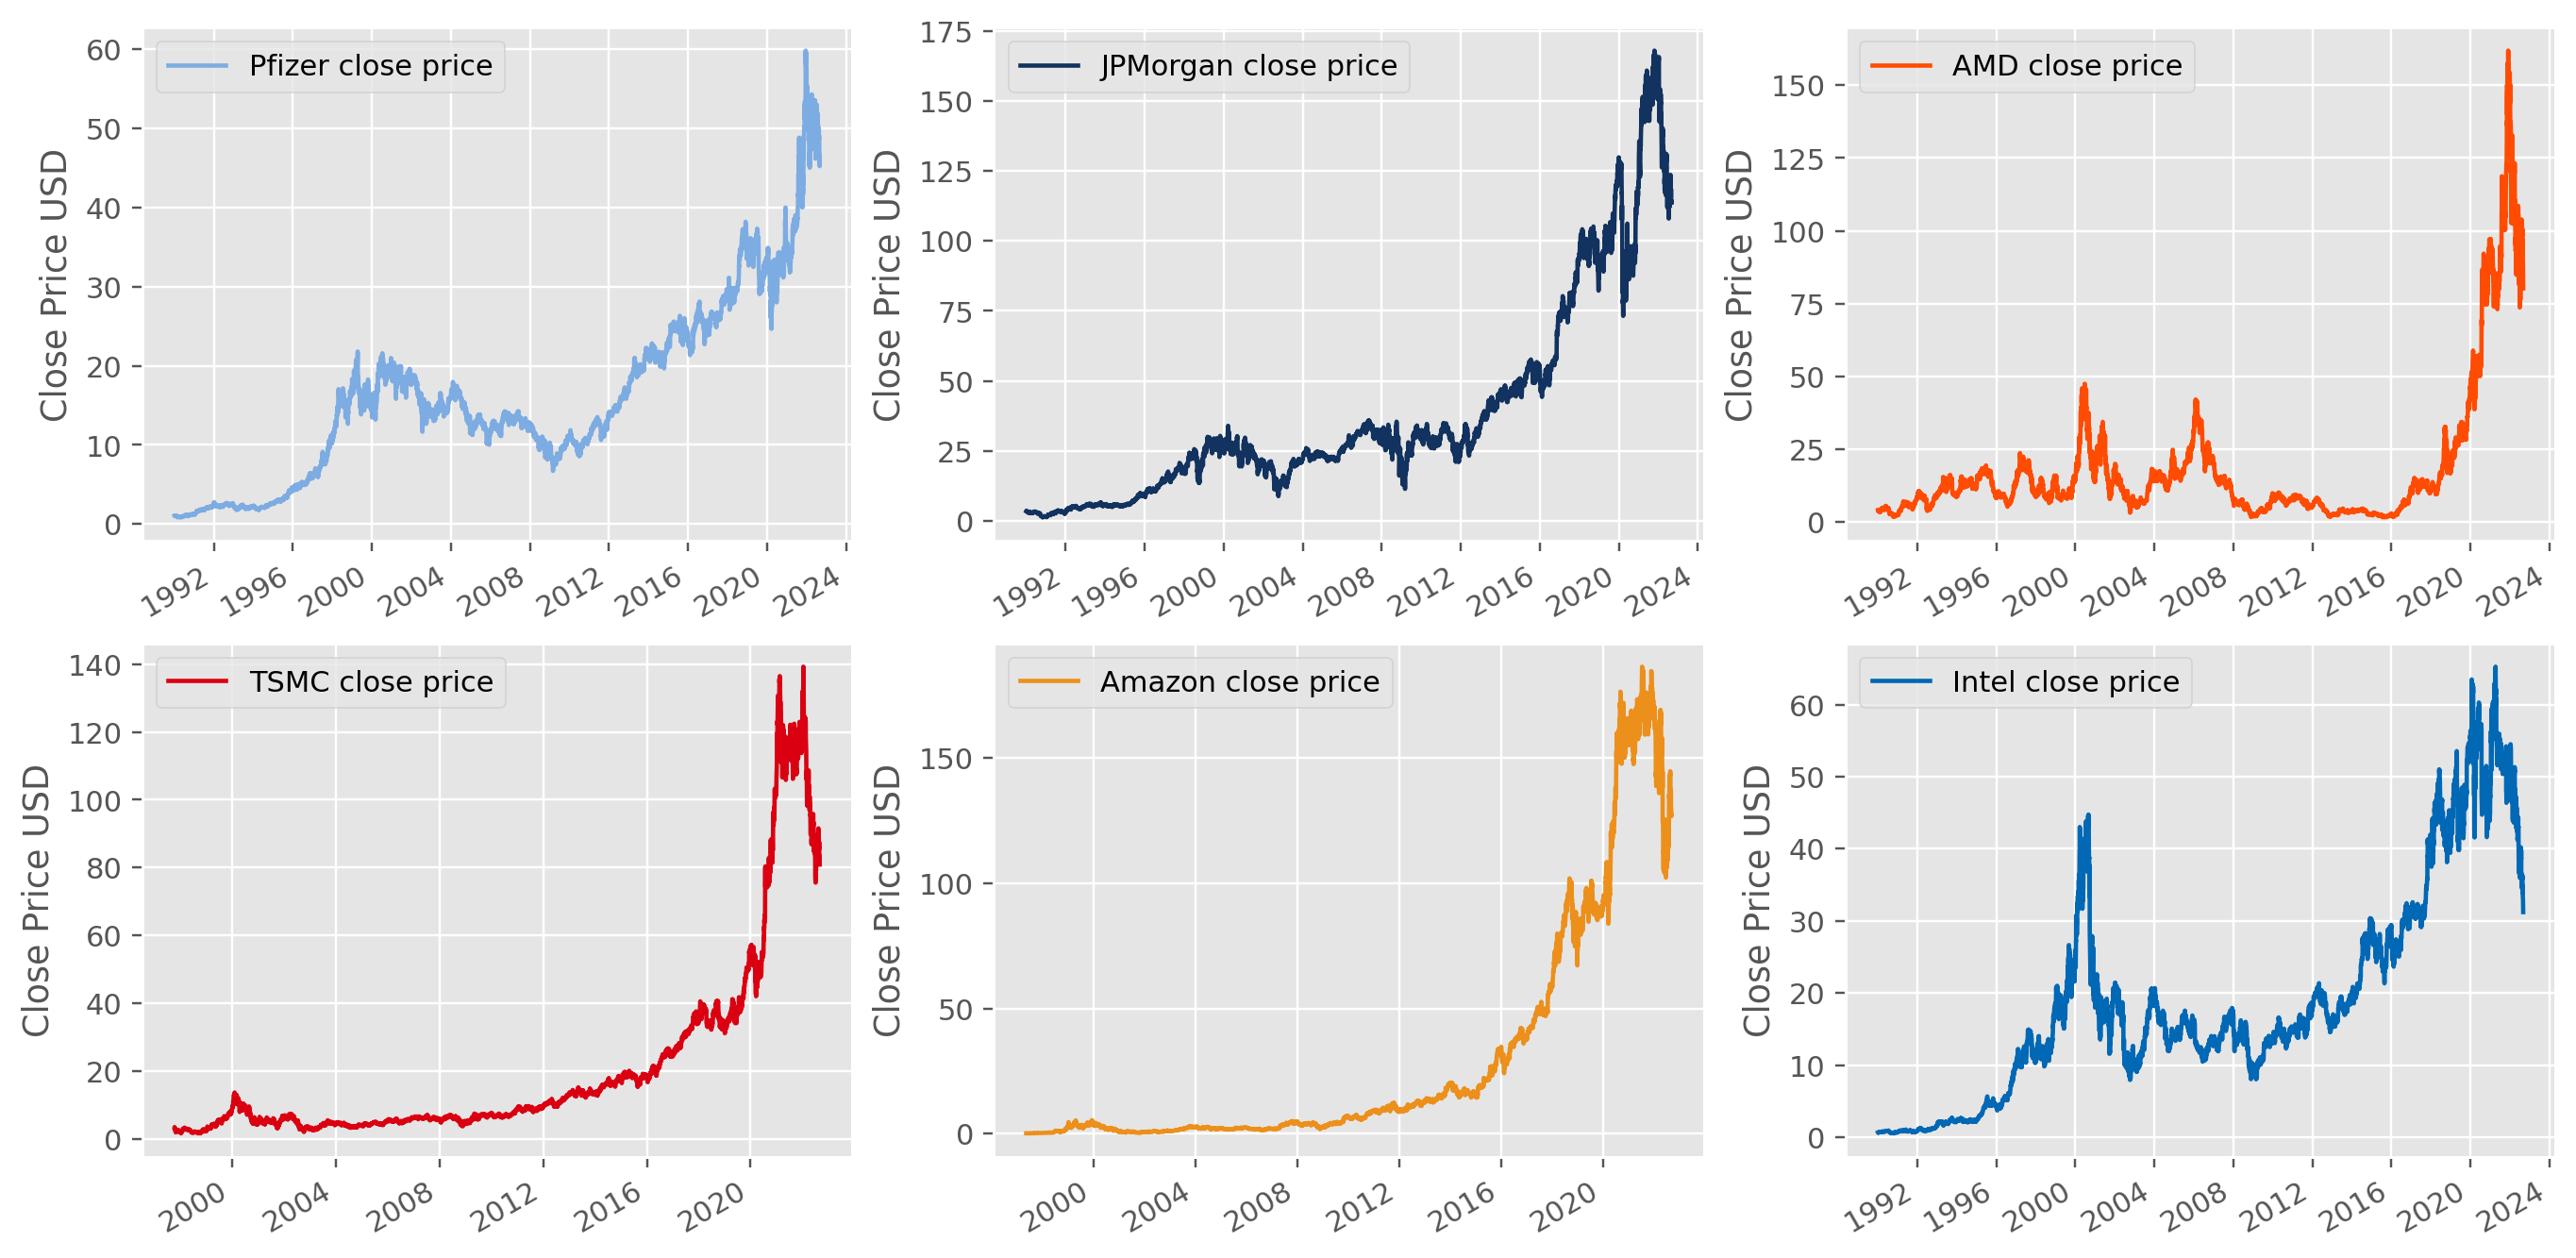

Figure 1: Close Price over time for companies of interest


In [ ]:
fig, axes = plt.subplots(figsize=(15,8), dpi=220, nrows=2, ncols=3)

for i,ticker in enumerate(tickers):
    company_history[ticker]["hist_daily"]["Close"].plot.line(ax=axes[i%2][i%3], ylabel="Close Price USD",
                                                        label=f"{ticker2name[ticker]} close price", xlabel="",
                                                       legend=True, color = ticker2color[ticker])

plt.show()
print("Figure 1: Close Price over time for companies of interest")

In [ ]:
print("Table 1: descriptive statistics for the studied stocks")
company_stats_df

Table 1: descriptive statistics for the studied stocks


,ticker,Mean_weekly_return,std_weekly_return,Mean_weekly_volume,std_weekly_volume,weekly_ups,weekly_downs,mean_weekly_ups,mean_weekly_downs
0,PFE,0.002,0.034,1.249991e+08,8.913817e+07,772,703,0.031,-0.028
1,AMZN,0.008,0.076,6.951087e+08,5.745658e+08,637,564,0.059,-0.049
2,AMD,0.003,0.083,1.086379e+08,1.329039e+08,788,800,0.069,-0.062
3,TSM,0.004,0.057,4.599433e+07,2.599301e+07,598,570,0.048,-0.041
4,JPM,0.003,0.049,7.473693e+07,8.093354e+07,783,709,0.039,-0.036
5,INTC,0.003,0.048,2.677623e+08,1.393277e+08,809,715,0.041,-0.038


For the companies that we are going to use, we chose six companies grouped into four groups:
1. Technical (TSMC, AMD, INTEL)
2. Pharmaceutical (Pfizer)
3. E-Commerce (Amazon)
4. Banking (JPMorgan)
 
We chose the first group to study the influence of the supply chain crisis and the China-Taiwan Conflict on technology companies. In contrast, the second group shows the investment opportunities produced by the global crisis of COVID-19, as what happened with Pfizer. In the third and fourth groups, we are interested in the consequences of the dot-com bubble on both dot-com companies and banks.
 
As shown in figure[1], the stock price of the first group is starting to decline due to the supply chain crisis and the China-Taiwan conflict; as you can see in the sub-charts of figure[1], they have a very similar declining signature. In late 2019 Covid-19 hit the world, and some companies have profited from this crisis, namely Pfizer where we can see sky-rocketing stock price after the approval of their Covid-19 vaccine. Regarding the dot-com bubble, which happened in late 2002, we study two companies involved in this event. Amazon -a dot-com company- and an investment company like JPMorgan.
 
By applying simple descriptive statistics on the weekly stock prices, we can analyse the overall performance of the chosen companies, we chose to use weekly data to have more stable analysis. The four used descriptive statistics are:
1.  Mean and standard deviation of the weekly-return, this information allows us to see how promising the investment in a company is, the higher the mean return is, the higher you will gain from investing in this company, one should also have a look at the standard deviation to have a more comprehensive view.
2. Mean and standard deviation of the weekly-volume, this value shows the overall magnitude of stock movement, higher valome shows higher number of buys and sells, and higher number of these two means higher interest and trust on the company, note that this is our interpretation of these values, and it might not be applicable in all scenarios.
3. Weekly ups-to-downs-ratio, to calculate this ratio, we count the number of times where the weekly return is higher than 0.5% and call this number (ups), while (downs) is the count of times in which the weekly return goes below -0.5%.
4. Mean weekly-ups-to-downs, while the weekly ups to downs ratio shows the count of the ups and downs, the mean weekly ups to downs reveals the return’s mean of the ups and downs.
 
Using the last two statistics, we can mesure the overall performance of a company, for example a company with ups higher than downs might be a good investment opportunity.
 
For example, from table[1], if we look at the four statistics for Amazon, it has a mean return of 0.008, a mean volume of 600 million, high weekly ups:downs ratio of 637:565, and the return’s mean of ups and downs are 0.059, -0.049 respectively.


## Task 2:

2. Train an agent for each company with the standard time period (2012-01-01 until 2017-21-31) for at least five times. In the standard setting, the agent will use all technical indicators provided by the pandas_ta package (this is done by the data preprocessing function within the environent you are using). This leads to high dimensional state variables. Because of this and the fact that during training, episodes start at random points in time, agents can learn different things and can have a hard time learning anything. Examine the general performance of the agent in comparison to a buy and hold strategy. Focus on the fraction of the agent being better than the buy and hold strategy. Also analyze the actions the trained agent chooses using the "analyze_actions_taken" function. What do you observe? 

Note: A short example how you can install the course environment, work with it and train agents is presented [here](https://colab.research.google.com/drive/1xKk5hwJnpVbwDLtRph_KWuTIKlIIjpCL?usp=sharing). Furthermore, you can find the environment code on my [personal github site](https://www.github.com/RalfKellner/aif_course). The TradingEnvironment class is adjusted from Stefan Jansen's github which you can see [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/22_deep_reinforcement_learning/trading_env.py). I adjusted his environment with respect to downloading data from yahoo finance, calculating more technical indicators in an automated fashion and applying a slightly different scaling logic to raw input data. The TradingEnvironment class in the course environment is the same as in Stefan Jansen's code. Basically, we calculate technical indicators using stock price information until time $t-1$ and use this information together with the log-return from $t-1$ until $t$ to choose an action which is either a long, cash or short position in the stock at time $t+1$. This position is held until $t+2$ and the financial success is measured as the log-return from $t+1$ until $t+2$ which is the reward in RL. Additionally, I implemented the TradingEnvironmentNew class which has a more simplified trading logic. Basically, we get technical indicator information for data until $t$, choose an action and determine the success of this action by the log-return from $t$ until $t + 1$. This implies the simplified assumption that we can observe today's closing price and buy or sell the stock for this amount. The TradingEnvironmentNew comes with a little more promising trading success than Stefan Jansen's trading logic which has one more time delay avoiding the simpliying assumption. NOTE: you can choose among both environment classes for your assignment, however, is you choose one please stick to it for the whole assignment! If you use the TradingEnvironmentNew class, make sure to set the environment_new argument to True for the analyze_actions_taken function. 

Further notes: it may have a strong impact on your results for how many steps you train the agent. Try out different numbers of training steps for yourself and stick to one number after that for the remainder of your project assignment. Also note that training an agent for various times usually results in trained agents with different policies. This is why I want you to train agents five times. Because of that, specific results are not so important, we are rather interested in the average of outcomes for trained agents.

*Do not use more than 250 words!*

### Task 2 - Answer:


In [ ]:
def train_agent(ticker, start_dates = ['2012-01-01'], end_dates = ['2017-12-31'], 
                use_variables=[], train_num=5, plot_results=False, verbose=0, 
                total_timesteps = 10_000, model=None):
    
    # Handle errors
    if not (len(start_dates)==len(end_dates)==train_num):
        print(f"Error: the entered dates should be {train_num}, the same number of train_num")
        return None, None, None
        
    res_list = []
    for i in range(train_num):
        env = TradingEnvironmentNew(ticker = ticker, start_date = start_dates[i], 
                                end_date = end_dates[i], use_variables=use_variables)
        # initialize and train the agent
        if model:
            model_ = eval(f"{model}(policy = 'MlpPolicy', env=env, verbose = verbose)")
        else:    
            model_ = A2C('MlpPolicy', env, verbose = verbose)
        

        model_.learn(total_timesteps = total_timesteps)
        
        res_list.append(ai_trade_performance(env, model_, num_plays = 20, plot_results=plot_results))
        
    return env, model_, res_list

# DocString
train_agent.__doc__ = \
"""Train Agent
Train a RL agent on data of a given company in the given dates
Args:
    ticker (string): the ticker of the company 
    start_dates (list): list of dates to be used as the start date of the training period , Default: ['2012-01-01']
    end_dates (list): list of dates to be used as the end date of the training period, Default:['2017-12-31']
    use_variables (list): names of technical indicators to be used, Default:[] which means use all of them
    train_num (int): number of times to train the model, Default:5
    plot_results (bool): if True, it will plot some plots of the model's performance, Default:False
    verbose (int): controls the verbosity, Default:0 
    total_timesteps (int): number of timesteps used for the training, Default: 10_000
    model (str): the name of the model as mentioned in the stable-baselines3 library, when None, it will use A2C, Default:None
    
Returns:
    env (TradingEnvironmentNew object): the environment instance
    model_: The trained model
    res_list (list of tuple): a tuple per each training (the length of this list = train_num) :
    each tuple contains:
        - A dataframe of the average performance 
        - An array of the agent's return (one number per play)
        - An array of the market's return (the performance of the buy and hold strategy) (one number per play)
"""

#### Timesteps Gridsearch:

In [ ]:
start_dates = ['2012-01-01','2012-01-01','2012-01-01','2012-01-01','2012-01-01']
end_dates   = ['2017-12-31','2017-12-31','2017-12-31','2017-12-31','2017-12-31']
total_timesteps_vals = [10_000, 25_000, 75_000, 100_000] 
timesteps_result = []
timesteps_result_time = []
for timestep in tqdm(total_timesteps_vals):
    start = time.time()
    _,_,res_list = train_agent(ticker="INTC",start_dates=start_dates, end_dates=end_dates,
                                    total_timesteps=timestep)
    end = time.time()
    timesteps_result.append(np.mean([(r[0].loc["return"]["agent_avg"], r[0].loc["return"]["agent_better"]) for r in res_list], axis=0))
    timesteps_result_time.append(round((end-start)/60))

# To clear the output logs
clear_output(wait=False)

In [ ]:
# training times (minutes)
timesteps_result_time

[5, 9, 25, 32]

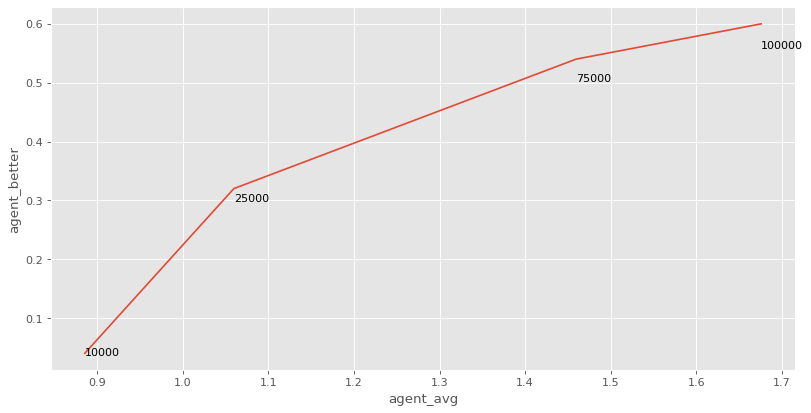

In [ ]:
X = [r[0] for r in timesteps_result]
Y = [r[1] for r in timesteps_result]
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(X, Y)
for t,x,y in zip(total_timesteps_vals,X,Y):
    plt.text(x, y-0.07*y, t)
plt.xlabel("agent_avg")
plt.ylabel("agent_better")
plt.show()

Figure 2: Result of the timesteps gridsearch

From Figure[2] we ca nsee that using 75,000 timesteps is reasonable choice as it has a high performance and lower training time.

In [ ]:
def train_on_companies(tickers, start_dates = ['2012-01-01'], end_dates = ['2017-12-31'],  
                use_variables=[], train_num=5, plot_results=False, total_timesteps=10_000):
    
    # Handle errors
    if not (len(start_dates)==len(end_dates)==train_num):
        print(f"Error: the entered dates should be {train_num}, the same number of train_num")
        return None

    company_result = {} #{company: result}
    for ticker in tickers:
        print(f"\n\n###########{ticker}############### \n\n")
        env,model,res_list = train_agent(ticker=ticker,start_dates=start_dates, end_dates=end_dates, train_num=train_num, total_timesteps=total_timesteps)
        company_result[ticker]= {"env":env, "model":model, "res_list":res_list}
    return company_result

# DocString
train_on_companies.__doc__ = \
"""Train on Companies
Ginen a list of tickers, train an agent for each company
Args:
    tickers (list): the tickers of the companies 
    start_dates (list): list of dates to be used as the start date of the training period , Default: ['2012-01-01']
    end_dates (list): list of dates to be used as the end date of the training period, Default:['2017-12-31']
    use_variables (list): names of technical indicators to be used, Default:[] which means use all of them
    train_num (int): number of times to train the model, Default:5
    plot_results (bool): if True, it will plot some plots of the model's performance, Default:False
    total_timesteps (int): number of timesteps used for the training, Default: 10_000
    
Returns:
    company_result (dict): A dictionary of the pairs company_ticker: {company dictionay}: 
        each company dictionary contains:
            - env (TradingEnvironmentNew object): the environment instance
            - model_: The trained model
            - res_list (list of tuple): a tuple per each training (the length of this list = train_num)    
"""

In [ ]:
company_result = train_on_companies(tickers=tickers, total_timesteps=75_000, train_num=5,
                                    start_dates=start_dates, end_dates=end_dates)
# To clear the output logs
clear_output(wait=False)

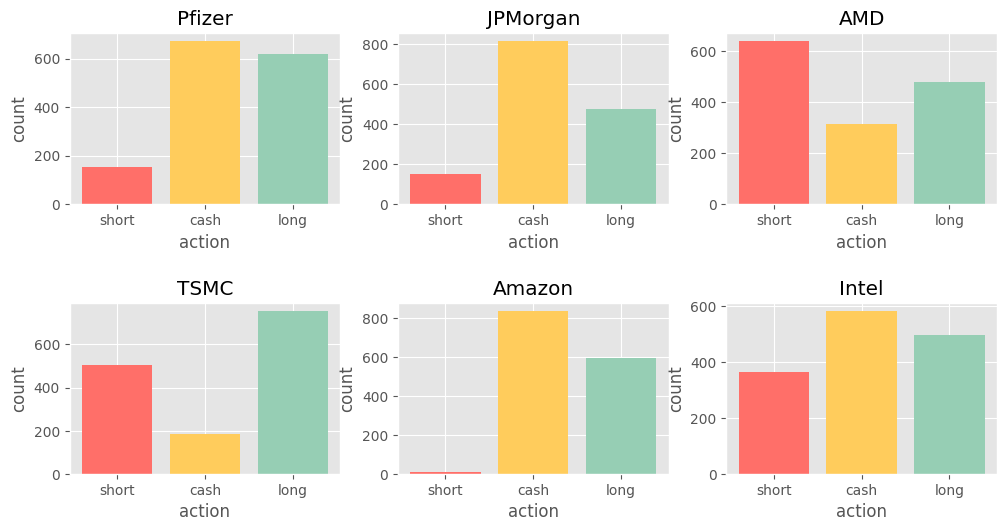

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), dpi=100, nrows=2, ncols=3)
fig.tight_layout(h_pad=5)
for i,ticker in enumerate(tickers):
    actions_count = analyze_actions_taken(environment=company_result[ticker]["env"], 
                                      model=company_result[ticker]["model"], 
                                      plot_actions = False, environment_new = True)
    axes[i%2][i%3].bar(actions_count.keys(), actions_count.values(), color = ['#ff6f69', '#ffcc5c', '#96ceb4'])

    axes[i%2][i%3].set_title(ticker2name[ticker])
    axes[i%2][i%3].set_xlabel('action')
    axes[i%2][i%3].set_ylabel('count')

Figure 3: Action distribution of different agents trained on 6 companies using all features (task 2)

In [ ]:
# Get the general_performance data for each company
for ticker in tickers:
    company_result[ticker]["general_performance"] = np.mean([(r[0].loc["return"]["agent_avg"], r[0].loc["return"]["market_avg"], r[0].loc["return"]["agent_better"]) for r in company_result[ticker]["res_list"]], axis=0)


overall_company_performance = []
for ticker in tickers:
    overall_company_performance.append({"Company":ticker2name[ticker], 
                                        "General_Agent_Performance":company_result[ticker]["general_performance"][0], 
                                        "General_Market_Performance":company_result[ticker]["general_performance"][1], 
                                        "Average_Agent_Better":company_result[ticker]["general_performance"][2]})
        
overall_company_performance_df = pd.DataFrame(data = overall_company_performance)

overall_company_performance_df

,Company,General_Agent_Performance,General_Market_Performance,Average_Agent_Better
0,Pfizer,1.124656,1.094431,0.57
1,Amazon,1.894547,1.346856,0.56
2,AMD,5.964462,1.976510,0.89
3,TSMC,1.739412,1.247324,0.67
4,JPMorgan,1.338209,1.182788,0.63
5,Intel,1.451722,1.206274,0.57


Table 2: Agents performance on 6 companies (task 2)

In this task, 6 agents are trained on 6 different companies, one agent per company trained 5 times on the standard time period, and the average of the result for these 5 times are reported in the table[2] above. As you can see, the general performance of all agents surpasses the buy and hold strategy. For example, the agent that was trained on AMD stocks get a return of around 6, which is approximately three times the average return of the buy and hold strategy, this means that if you invest one dollar in AMD and used our trained agent, you will get around 6 dollars by the end of the episode (252 trading days) . Furthermore, In around 90% of the trading days, our agent took actions better than the buy and hold strategy. To see the performance of the other agents, check table[2].

Figure[3] illustrates the distribution of the actions taken by each agent, for instance, the agent which was trained on AMD's stock history, prefered shorting rather than longing nor cashing, we believe the agent has learnt that on average the best action to take is to short, this is due to the fact that the number of downs is higher than the number of ups (as shown in the discriptive statistics of AMD in table[1].

In contrast, the other companies prefereed actiones other than short because their number of downs is lower than their ups, and this shows potential use of the ups-to-downs ratio.

## Task 3:
3. Choose five technical indicators that you find interesting. Describe them using mathematical notation and describe in your own words which pattern the indicator is supposed to capture. To find out how you can write mathematical equations in a jupyter notebook you may want to google "write math equations in jupyter notebook" and learn by one of the hits which matches your needs.

Note: see this [video](https://vimeo.com/725995520/a305a54d21), where I show you how you best proceed to find out how technical indicators are calculated within the pandas_ta package and how they are named.

For example, the awesome oscillator is:

$$
AO_t = SMA_t^f(M_t) - SMA_t^s(M_t)
$$

with

$$
M_t = \frac{H_t + L_t}{2}
$$

$H_t, L_t$ being the highest and lowest stock price at day $t$ and 

$$
SMA_t^h(M_t) = \frac{M_{t} + M_{t-1} + M_{t-2} + ... + M_{t-h}}{h}
$$

being the simple moving average for the last $h$ days. Usually, $f<s$ is chosen when calculating $AO_t$ which means it compares a short sighted trend in the stock price with a longer trend. A positive value indicates a higher stock price level more recently, while more recent stock prices are smaller on average if $AO_t$ is negative. 

After you have decided which technical indicators to use, train an agent for five times and compare your results to the previous analysis using all technical indicators. What are your findings?

*Do not use more than 250 words!*

### Task 3 - Answer:

The 10 features (technical indicators) (5 for each team member) that we are going to explain are:

<h3> 1. Center of Gravity (CG) </h3>
The Center of Gravity Indicator identifies turning points while exhibiting zero lag and smoothing.

$$CG = \frac{\sum_{i=0}^N (x_i +1)* close_i}{\sum_{i=0}^N close_i}$$

Where:

- _N_: Time period
- _close_i_: Close price of specific day i
- _x_i_: Count of the days from starting period till the current day in the loop

**Potential Captured Pattern:** Turning points



For more details: [TheCGOscillator](http://www.mesasoftware.com/papers/TheCGOscillator.pdf)

---

<h3> 2. Bias (bias) </h3>
Rate of change between the source and a moving average.

Default Inputs:
- _length_=26 (The period)
- _MA_='sma' (MA stands for moving average) and sma is "Simple Moving Average"

$$ bias = \frac{close}{moving\_average} - 1 $$

**Potential Captured Pattern:** change rate of the stock

For more details: [Pandas TA - Bias]()

---

<h3> 3. Slope (slope) </h3>
The slope of a series of length n, it can also convert the slope to angle when you set $ as\_angle=True$.
Slope is calculated as follows:
$$ slope_{t} = close_{t} - close_{t-length} $$
Where $ length $ is the length of the window.

**Potential Captured Pattern:** The amount and direction of the stock change (the slope)

For more details: [Pandas TA - Slope](https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/momentum/slope.py)

---

<h3> 4. Even better Sinewave (ebsw) </h3>
With the help of a low pass filter, this indicator determines market cycles. The maximum length of a detected trend is constrained by the length input and is output as a bound signal in the range of -1 and 1. Because of its filtering ability, this indicator can display both bullish and bearish cycle momentum of price, as well as some lagging effects. It should be used as a filter, as opposed to being used on its own.

Default Inputs:
- _length_ (int): It's max cycle/trend period. Values between 40-48 work like expected with minimum value: 39. Default: 40.
- _bars_ (int): Period of low pass filtering. Default: 10
- _drift_ (int): The difference period. Default: 1

$$ sineWave = \frac{Wave}{\sqrt{Pwr}} $$

**Potential Captured Pattern:** Market cycles

For more details: [Even better Sinewave](https://www.prorealcode.com/prorealtime-indicators/even-better-sinewave/)

---

<h3> 5. Log Return (log_return) </h3>

Calculates the logarithmic return.
$$ log\_return = log(return) $$
Where:
$$ return = \frac{close_{t}}{close_{t-length}} $$

Default Inputs:
- length (int): (The period) Default: 1

**Potential Captured Pattern:** Log change of stock price

For more details: [logarithmic returns in pandas dataframe](https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe)

---

<h3> 6. Short Run (short_run) </h3>

Calculates a boolean variable, this variable equlas 1 is there exist short run and 0 otherwise.

$$ f(x)= 
\begin{cases}
    1,& \text{if } \text{short run}\\
    0,              & \text{no short run}
\end{cases}  $$
Short run is where there are some constraints and markets are not fully in equilibrium.

For more details: [Long run and short run](https://en.wikipedia.org/wiki/Long_run_and_short_run), [pandas_ta](https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/short_run.py)

---

<h3> 7. Skew (skew) </h3>

Calculates the skewness of a window of a certain length, the skewness is a measure of asymmetry of a distribution.

$$
\tilde{\mu}_3=\frac{\sum_i^N\left(X_i-\bar{X}\right)^3}{(N-1) * \sigma^3}
$$
$\tilde{\mu}_3=$ skewness

$N=$ number of variables in the distribution

$X_i=$ random variable

$\bar{X}=$ mean of the distribution

**Potential Captured Pattern:** The skewness of the stock price

For more details: [Pandas TA - Skew](https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/statistics/skew.py)

---

<h3> 8. Percent Return (percent_return) </h3>

Calculates the percent return.

$$ \text{Percent Return} = \frac{Close_{t} - Open_{t}}{Open_{t}}$$

**Potential Captured Pattern:** The rate of the stock change

For more details: [Pandas TA - Percent Return](https://github.com/twopirllc/pandas ta/blob/main/pandas_ta/performance/percent_return.py)

---

<h3> 9. Rolling Quantile (quantile) </h3>

Calculates the rolling quantile.

For example, the 0.5 quantile is the value where 50% of the data is located below it and the other 50% is higher than it 
Default Inputs:
- length=30
- q=0.5


For more details: [Pandas TA - Quantile](https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/statistics/quantile.py)


---

<h3> 10. Median (median) </h3>

Rolling Median of over 'n' periods. Sibling of a Simple Moving Average.

$ MED(X) = \begin{cases}X\left[\frac{n}{2}\right] & \text { if } n \text { is even } \\ \frac{\left(X\left[\frac{n-1}{2}\right]+X\left[\frac{n+1}{2}\right]\right)}{2} & \text { if } n \text { is odd }\end{cases} $

$X$ = ordered list of values in data set

$n=$ number of values in data set


For more details: [Pandas TA - Median](https://www.incrediblecharts.com/indicators/median_price.php)



In [ ]:
# # enter your code here
use_variables = ["bias", "cg", "slope", "ebsw", "log_return", 
                 "percent_return", "median", "quantile", "short_run", "skew"]

In [ ]:
company_result = train_on_companies(tickers=tickers, total_timesteps=75_000, train_num=5, use_variables = use_variables,
                                   start_dates=start_dates, end_dates=end_dates)
# To clear the output logs
clear_output(wait=False)

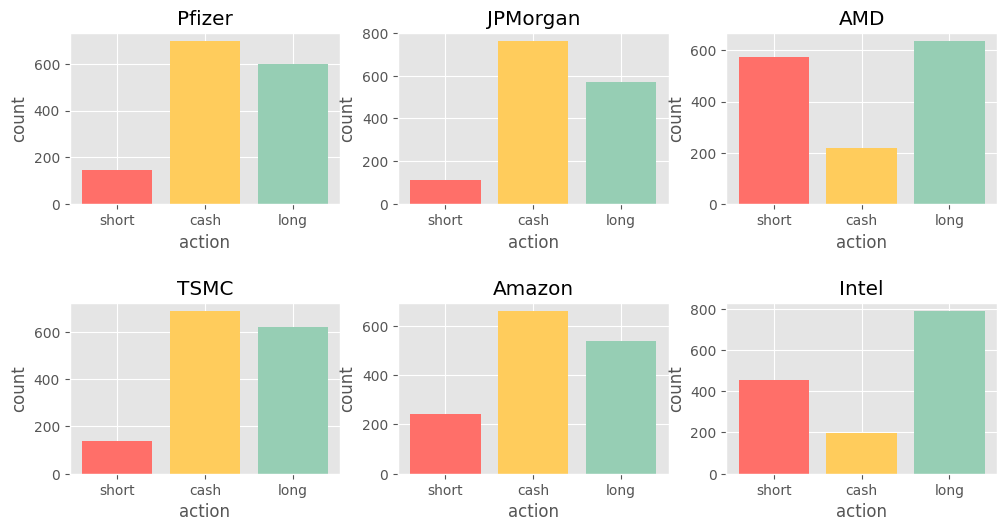

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), dpi=100, nrows=2, ncols=3)
fig.tight_layout(h_pad=5)
for i,ticker in enumerate(tickers):
    actions_count = analyze_actions_taken(environment=company_result[ticker]["env"], 
                                      model=company_result[ticker]["model"], 
                                      plot_actions = False, environment_new = True)
    axes[i%2][i%3].bar(actions_count.keys(), actions_count.values(), color = ['#ff6f69', '#ffcc5c', '#96ceb4'])

    axes[i%2][i%3].set_title(ticker2name[ticker])
    axes[i%2][i%3].set_xlabel('action')
    axes[i%2][i%3].set_ylabel('count')

Figure 4: Action distribution of different agents trained on 6 companies using manually-selected features.

In [ ]:
# Get the general_performance data for each company
for ticker in tickers:
    company_result[ticker]["general_performance"] = np.mean([(r[0].loc["return"]["agent_avg"], r[0].loc["return"]["market_avg"], r[0].loc["return"]["agent_better"]) for r in company_result[ticker]["res_list"]], axis=0)


overall_company_performance = []
for ticker in tickers:
    overall_company_performance.append({"Company":ticker2name[ticker], 
                                        "General_Agent_Performance":company_result[ticker]["general_performance"][0], 
                                        "General_Market_Performance":company_result[ticker]["general_performance"][1], 
                                        "Average_Agent_Better":company_result[ticker]["general_performance"][2]})
        
overall_company_performance_df = pd.DataFrame(data = overall_company_performance)

overall_company_performance_df

,Company,General_Agent_Performance,General_Market_Performance,Average_Agent_Better
0,Pfizer,1.309663,1.056212,0.83
1,Amazon,2.253345,1.369017,0.66
2,AMD,7.748465,1.707766,0.99
3,TSMC,1.382718,1.285986,0.46
4,JPMorgan,1.262995,1.203576,0.52
5,Intel,1.536619,1.212813,0.58


Table 3: Agents performance on 6 companies (task 3)

Comparing the results from table[2] (agents trained on all variables) and table[3] (agents trained on ten manually-picked variables), we can see that using fewer variables increases the overall performance of the agents; we believe this is due to the fact that using too many variables makes it harder for the agent to learn useful patterns, so, selecting features with some potential patterns cannot do anything but increasing the performance of the trained model. Further analysis and tests must be done to have more robust and generalised results.

Comapring the performance of the agent trained on AMD, using all the variables gives a general agent performance of around 6 and average agent better of 90%, on the other hand, using only ten manually-selected features, the agent got a general performance of 7.7 and it was better than the buy and hold strategy in 99% of the actions.

## Task 4:
4. Now, let us find out if it helps to reduce the dimensionality of the state space and select a few technical indicators. We will select indicators which correlate the most to tomorrow's log-return of the close price. In the code below, you can see how I do this for the Apple stock. You can decide how many of the most correlated state variables you want to use. To do so just copy the list and give it to the "use_variables" argument of the environment. Again, train the agent in the same way as before and compare your results. What are your findings?

Note: your are welcome to try different approaches for selecting technical indicators, be creative if you want!

*Do not use more than 250 words!*

### Task 4 - Answer:


In [ ]:
def get_most_correlated(tickers=["AMD"], top_n=10, methods=["spearman", "pearson", "kendall"]):
    feat_freq_corr = {} # for each feature keep frquency and cummulative feature correlation
    for ticker in tickers:
        for method in methods:
            # download data
            cmpny = yf.Ticker(ticker)
            df_raw = cmpny.history(start = '2012-01-01', end = '2017-12-31')

            # prepare the data as within the environment
            df = df_raw.copy()
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            df.loc[:, 'returns'] = np.log(df.Close) - np.log(df.Close.shift(1))

            # this is tomorrow's log-return
            df.loc[:, 'returns_target'] = df.returns.shift(-1)
            df.ta.strategy()

            # these variables need to be deleted as they include data from the future
            # this is called data leakage and creates superior results, however, is not applicable for real-life trading
            df.drop(['DPO_20', 'ISA_9', 'ISB_26', 'ITS_9', 'ICS_26', 'IKS_26'], axis = 1, inplace = True)

            # delete indicators with too many missing values (fraction of missing instances is higher than 5%)
            cols_to_drop = df.columns[df.isnull().mean() > 0.05]
            df.drop(cols_to_drop, axis = 1, inplace = True)
            # delete rows with missing data
            df.dropna(inplace = True)

            corr_df = df.corr(method = method).returns_target.abs().sort_values(ascending = False)[1:top_n+1]
            corr_df.dropna(inplace = True)
            freq_importance = [(i, v) for i, v in zip(corr_df.index, corr_df.values)] 

            for f, c in freq_importance:
                if f not in feat_freq_corr:
                    feat_freq_corr[f] = [0,0]
                    feat_freq_corr[f][0] = 1
                    feat_freq_corr[f][1] = c
                else:
                    feat_freq_corr[f][0] += 1
                    feat_freq_corr[f][1] += c
    
    return feat_freq_corr


# DocString
get_most_correlated.__doc__ = \
"""Get Most Correlated
Returns a list of the most correlated features to the return.
This function is explained in the next cells of this notebook (task 4 answer)
Args:
    tickers (list): the tickers of the used companies , Default: ['AMD'] 
    top_n (int): how many features to return, Default: 10
    methods (list): list of correlation methods used , Default: ["spearman", "pearson", "kendall"]
    
Returns:
    feat_freq_corr (dict): for each feature keep frquency and cummulative feature correlation in this dictionary {"feature name":[frequency, correlation]}
"""

In [ ]:
feat_freq_corr = get_most_correlated(tickers=tickers, top_n=10, methods=["spearman", "pearson", "kendall"])

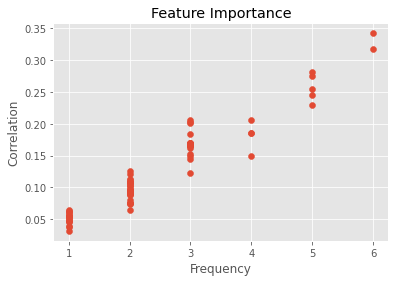

In [ ]:
plt.scatter([f[0] for f in feat_freq_corr.values()], [f[1] for f in feat_freq_corr.values()])
plt.title("Feature Importance")
plt.xlabel("Frequency")
plt.ylabel("Correlation")
plt.show()


Figure 5: Feature frequency, commulative correlation

To measure the importance of the features we implemented the next algorithm:
1. Calculate the correlation of each feature with the return (do this three times, one time per correlation method)
2. Get a list of the most related features for each company
3. Calculate the cummulative feature correlation, and the frequancy of the features using all the list of features we get from step 2
4. Plot a scatter plot of (Feature frequancy, cummulative feature correlation) points taken from step 3, this plot is then used to roughly find two thresholds, one for frequancy and another for correlation value.
5. Select all features that have values above the two thresholds (i.e. select all features whith frequancy >= 3 and correlation >= 0.2 )


From the above chart, we will select all features that have a fequency of 3 or above, and correlation of 0.2 or above.

In [ ]:
selected_features = [feat for feat,(freq,corr) in feat_freq_corr.items() if freq>=3 and corr>=0.2]

In [ ]:
def plot_feature_piechart(feat_freq_corr):
    sum_corrs = sum([corr for (freq,corr) in feat_freq_corr.values() if freq>=3 and corr>=0.2])
    selected_features = [(feat,corr/sum_corrs) for feat,(freq,corr) in feat_freq_corr.items() if freq>=3 and corr>=0.2]
    feature_names = [f[0] for f in selected_features]
    feature_corrs = [f[1] for f in selected_features]
    fig = px.pie(values=feature_corrs, names=feature_names, title='Correlations')
    fig.update_traces(textposition='inside', textinfo='percent+label', insidetextorientation='radial')
    fig.show()

In [ ]:
plot_feature_piechart(feat_freq_corr)

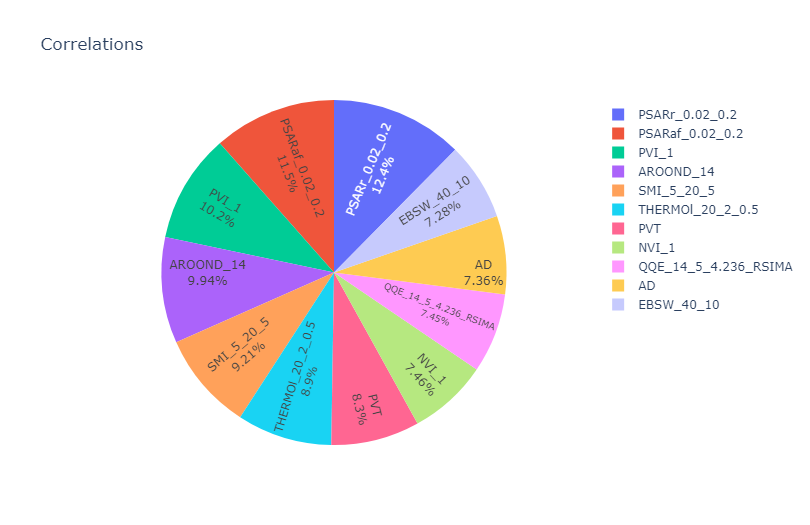

Figure 6: Top 10 corelated features

In [ ]:
use_variables = selected_features

In [ ]:
# Train agents using the most correlated features
company_result = train_on_companies(tickers=tickers, total_timesteps=75_000, train_num=5, use_variables = use_variables, 
                                    start_dates=start_dates, end_dates=end_dates)
# To clear the output logs
clear_output(wait=False)

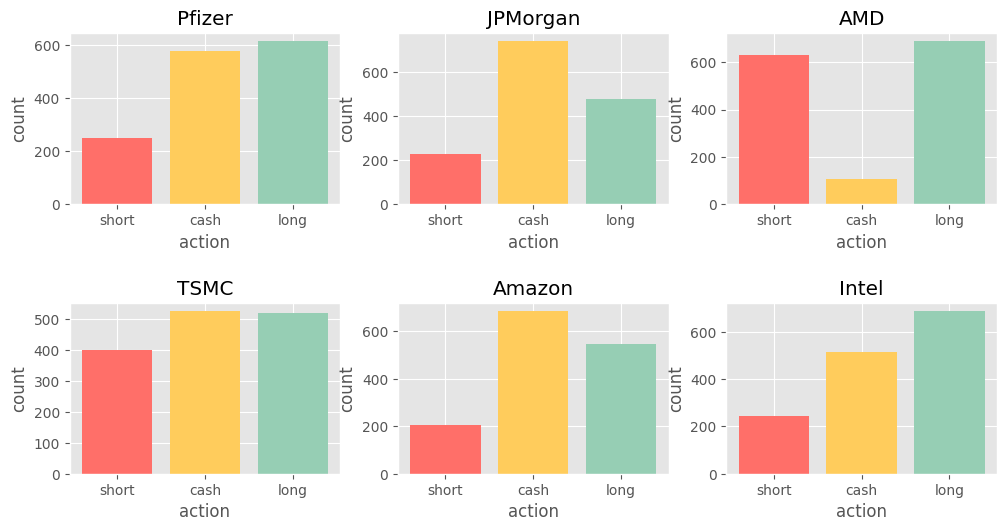

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), dpi=100, nrows=2, ncols=3)
fig.tight_layout(h_pad=5)
for i,ticker in enumerate(tickers):
    actions_count = analyze_actions_taken(environment=company_result[ticker]["env"], 
                                      model=company_result[ticker]["model"], 
                                      plot_actions = False, environment_new = True)
    axes[i%2][i%3].bar(actions_count.keys(), actions_count.values(), color = ['#ff6f69', '#ffcc5c', '#96ceb4'])

    axes[i%2][i%3].set_title(ticker2name[ticker])
    axes[i%2][i%3].set_xlabel('action')
    axes[i%2][i%3].set_ylabel('count')

Figure 7: Action distribution of different agents trained on 6 companies using the most correlated features to the return (task 4)

In [ ]:
# Get the general_performance data for each company
for ticker in tickers:
    company_result[ticker]["general_performance"] = np.mean([(r[0].loc["return"]["agent_avg"], r[0].loc["return"]["market_avg"], r[0].loc["return"]["agent_better"]) for r in company_result[ticker]["res_list"]], axis=0)


overall_company_performance = []
for ticker in tickers:
    overall_company_performance.append({"Company":ticker2name[ticker], 
                                        "General_Agent_Performance":company_result[ticker]["general_performance"][0], 
                                        "General_Market_Performance":company_result[ticker]["general_performance"][1], 
                                        "Average_Agent_Better":company_result[ticker]["general_performance"][2]})
        
overall_company_performance_df = pd.DataFrame(data = overall_company_performance)

overall_company_performance_df

,Company,General_Agent_Performance,General_Market_Performance,Average_Agent_Better
0,Pfizer,1.255129,1.056097,0.84
1,Amazon,1.923045,1.370101,0.66
2,AMD,9.918481,1.891384,1.00
3,TSMC,1.457796,1.272291,0.67
4,JPMorgan,1.564318,1.200413,0.72
5,Intel,1.285023,1.164061,0.50


Table 4: Agents performance on 6 companies using the most correlated features(task 4)

Comparing the results from table[3] (agents trained on ten manually-picked variables) and table[4] (agents trained on most correlated features), we can see that using more correlation to select the variables increases the overall performance of the agents. Comparing the performance of the agent trained on AMD, using ten picked-by-hand variables gives a general agent performance of around 8 and an average agent better of 99%. On the other side, using the most correlated variables, the agent got a general performance of approximately 10, and it was better than the buy and hold strategy in 100% of the actions.

## Task 5:
5. One important aspect is, if your trained agent is able to generate good results for new time periods which have not been used for training the agent. This is what your are supposed to find out. For five times set two time periods respectively, a training and a testing period (the five periods can overlap, however, always make sure that training and test periods do not overlap, e.g., train 2012-01 - 2015-12, test: 2016-01 - 2018-12, train: 2012-07 - 2016-6, test: 2016-07 - 2019-06, ...). Using all indicators train the agent on the training period. Hand the scaler of observations from the training period to the test environment and evaluate the performance of the trained agent for the test period. See one example below. What are your findings?

*Do not use more than 250 words!*

### Task 5 - Answer:


In [ ]:
def test_agent(ticker, model, start_dates = ['2012-01-01'], end_dates = ['2017-12-31'], 
                use_variables=[], test_num=5, plot_results=False):
    
    #ToDo: doc string
    
    # Handle errors
    if not (len(start_dates)==len(end_dates)==test_num):
        print(f"Error: the entered dates should be {test_num}, the same number of test_num")
        return None, None, None
        
    res_list = []
    for i in range(test_num):
        env = TradingEnvironmentNew(ticker = ticker, start_date = start_dates[i], 
                                end_date = end_dates[i], use_variables=use_variables)
        
        res_list.append(ai_trade_performance(env, model, num_plays = 20, plot_results=plot_results))
        
    return res_list

# DocString
test_agent.__doc__ = \
"""Test Agent
Tests a trained RL agent on data of a given company in the given dates
Args:
    ticker (string): the ticker of the company 
    start_dates (list): list of dates to be used as the start date of the test period , Default: ['2012-01-01']
    end_dates (list): list of dates to be used as the end date of the test period, Default:['2017-12-31']
    use_variables (list): names of technical indicators to be used, Default:[] which means use all of them
    plot_results (bool): if True, it will plot some plots of the model's performance, Default:False
    model (object): The trained model to test
    
Returns:
    res_list (list of tuple): a tuple per each test date (the length of this list = the length of start_dates) :
    each tuple contains:
        - A dataframe of the average performance 
        - An array of the agent's return (one number per play)
        - An array of the market's return (the performance of the buy and hold strategy) (one number per play)
"""

In [ ]:
train_start_dates = ['2000-01-01','2007-01-01','2013-01-01','2014-01-01','2015-01-01']
train_end_dates   = ['2002-12-31','2009-12-31','2015-12-31','2016-12-31','2017-12-31']

test_start_dates = ['2003-01-01','2010-01-01','2016-01-01','2017-01-01','2018-01-01']
test_end_dates   = ['2005-12-31','2012-12-31','2018-12-31','2019-12-31','2020-12-31']

As you can in the previous cell, we used certain dates to cover some events/crises:

- 2000 to 2002 : covers the dot-com bubble
- 2007 to 2009 : covers the 2008 financial crisis
- 2018 to late 2020: covers the Covid-19 crisis

In [ ]:
s = time.time()
train_company_result   = train_on_companies(tickers=tickers, total_timesteps=75_000, train_num=5,
                                            start_dates = train_start_dates, end_dates = train_end_dates)
# To clear the output logs
clear_output(wait=False)

print(f"Done in {time.time()-s} seconds")

Done in 8691.907539606094 seconds


In [ ]:
test_company_result   = {}
for ticker in tickers:
    model = train_company_result[ticker]["model"]
    test_company_result[ticker] = test_agent(ticker=ticker, test_num=len(test_start_dates),
                                                    model = model,
                                                    start_dates = test_start_dates, 
                                                    end_dates = test_end_dates)
# To clear the output logs
clear_output(wait=False)

In [ ]:
# Get the general_performance data for each company
for ticker in tickers:
    company_result[ticker]["general_performance"] = np.mean([(r[0].loc["return"]["agent_avg"], r[0].loc["return"]["market_avg"], r[0].loc["return"]["agent_better"]) for r in company_result[ticker]["res_list"]], axis=0)


overall_company_performance = []
for ticker in tickers:
    overall_company_performance.append({"Company":ticker2name[ticker], 
                                        "General_Agent_Performance":company_result[ticker]["general_performance"][0], 
                                        "General_Market_Performance":company_result[ticker]["general_performance"][1], 
                                        "Average_Agent_Better":company_result[ticker]["general_performance"][2]})
        
overall_company_performance_df = pd.DataFrame(data = overall_company_performance)

overall_company_performance_df

,Company,General_Agent_Performance,General_Market_Performance,Average_Agent_Better
0,Pfizer,1.255129,1.056097,0.84
1,Amazon,1.923045,1.370101,0.66
2,AMD,9.918481,1.891384,1.00
3,TSMC,1.457796,1.272291,0.67
4,JPMorgan,1.564318,1.200413,0.72
5,Intel,1.285023,1.164061,0.50


Table 5: Agents performance on 6 companies (task 5)

In [ ]:
performance_through_years = {}

for ticker in tickers:
    tmp_test = []
    tmp_train = []
    for i, (test_start_date, train_start_date) in enumerate(zip(test_start_dates, train_start_dates)):
        tmp_test.append({"start_date":test_start_date,
            "agent_avg":test_company_result[ticker][i][0].loc["return"]["agent_avg"],
            "market_avg":test_company_result[ticker][i][0].loc["return"]["market_avg"],
            "agent_better":test_company_result[ticker][i][0].loc["return"]["agent_better"] 
            })
        tmp_train.append({"start_date":train_start_date,
        "agent_avg":train_company_result[ticker]["res_list"][i][0].loc["return"]["agent_avg"],
        "market_avg":train_company_result[ticker]["res_list"][i][0].loc["return"]["market_avg"],
        "agent_better":train_company_result[ticker]["res_list"][i][0].loc["return"]["agent_better"] 
        })

    performance_through_years[ticker] = {"train": pd.DataFrame(tmp_train).set_index('start_date'),
                                         "test": pd.DataFrame(tmp_test).set_index('start_date')}
                                         


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

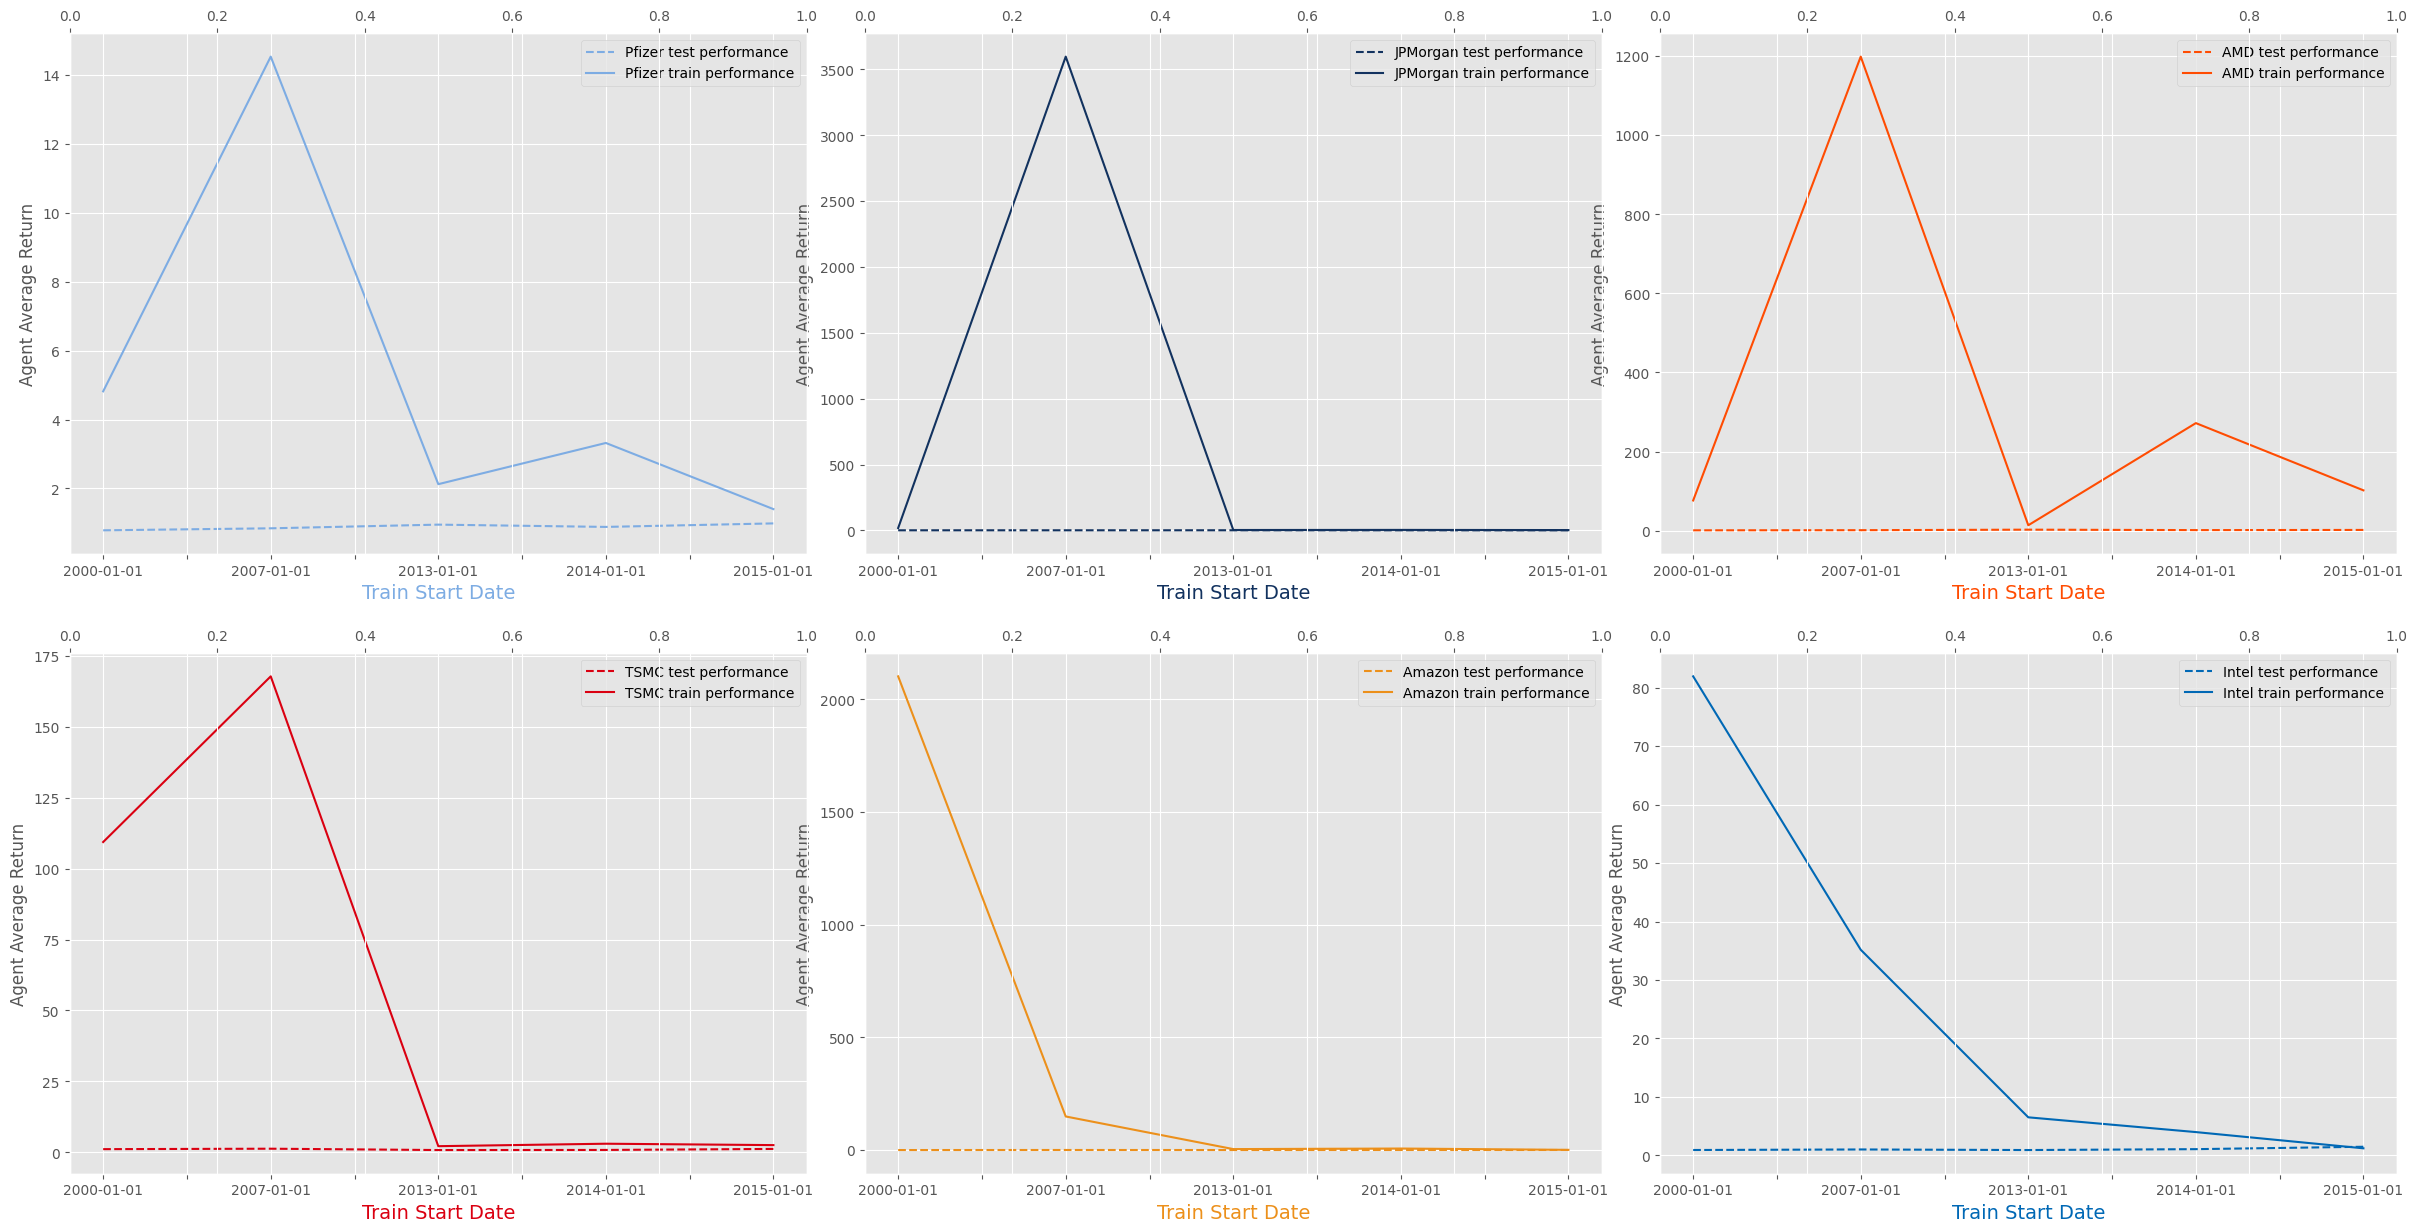

In [ ]:
fig, axes = plt.subplots(figsize=(24,12), dpi=100, nrows=2, ncols=3)
fig.tight_layout(h_pad=5)
for i,ticker in enumerate(tickers):
    performance_through_years[ticker]["test"]["agent_avg"].plot.line(ax=axes[i%2][i%3], ylabel="Agent Average Return",style='--',
                                                        label=f"{ticker2name[ticker]} test performance", xlabel="Test Start Date",
                                                        legend=True, color = ticker2color[ticker])
    
    axes[i%2][i%3].set_xlabel("Test Start Date", color = ticker2color[ticker], fontsize=14)
    axes[i%2][i%3].twiny()
    performance_through_years[ticker]["train"]["agent_avg"].plot.line(ax=axes[i%2][i%3], ylabel="Agent Average Return",
                                                        label=f"{ticker2name[ticker]} train performance", xlabel="TrainStart Date",
                                                        legend=True, color = ticker2color[ticker])
    axes[i%2][i%3].set_xlabel("Train Start Date", color = ticker2color[ticker], fontsize=14)
    


plt.show()

Figure 8 The x-axis shows the dates where the agent started the training, for all the agents, the training period is three years, and the test period is the next three years, for example, the agent that was trained on the data from 2013 to late 2015 will be tested on the data from 2016 to the last day of 2018.

Figure[8] shows that none of the trained agents on different companies generalized on the test data, which reflects the disability of the A2C model to generalize (at least not in the application of stock trading); however, this could be an issue of our chosen dates for training and testing as they include some anomalies such as the dot-com bubble, the Covid-10 crisis ... etc. Note that our previous analysis (in task 2,3, and 4) is so naive as it only depends on the results of training data. Thus, we need to test our model on data that was not previously seen by the agent for the sake of real judgement on model performance.

## Task 6:
6. Taking a look at your overall findings, do you think training artificial agents for making trading decisions is a promising approach? What are challenges and limitations? 

*Do not use more than 500 words*!

### Task 6 - Answer:
From our experiments, especially from task 5, we see that using reinforcement learning (RL) algorithms are not as promising as we thought it would be at the beginning of this assignment. Going through the tasks of this assignment taught us how hard it is to train RL agents and make ones which are capable of performing well on new data (not only A2C but also other algorithms such as DQN, PPO, TRPO, ..., etc [refer to our answer for the bonus task])

Regarding the challenges and limitations faced, the need for GPUs to train such RL models was one of the challenges we encountered. For example, if you want to do a hyperparameter tuning (say you want to find the optimal timesteps), then you might need more than three hours just to find a good-enough value for one hyperparameter, let alone searching for optimal values of 10 hyperparameters. Another limitation of RL algorithms is that they lack the ability to optimally learn from unstable data with anomalies; this is why we think that the used RL algorithms performed poorly on the stock market, and from our analysis in task 1, we see how unstable, and full-of-anomalies the stock market is. Another possible limitation might be the absence of multimodalities -data such as stock market news, trends, and even politics- might have a big impact and influence on the stock prices, but in this assignment, we only used numerical data of financial technical indicators. Reading the second paper we mentioned in task 7 you will see how useful multimodality is. Finally, If we are to continue working on using RL to train trading agents, we should use more data for the training process, this will allow the models to find useful and generalised patterns; furthermore, ensembling multiple models might be a good idea to try.



## Task 7:
7. It is always interesting how other people approach the application of reinforcement learning in the area of trading. Therefore, I want you to search for one scientific paper dealing with this content. Please use this platform for your search: https://www.webofscience.com/wos/woscc/basic-search

In this [video](https://vimeo.com/726005821/30fc88fd92 ), I give you a short explanation, how I want you to search for the papers.

Please make sure to describe with your own words what is done in the paper and what the main results are. Also make sure to provide a link to the paper (at least to the information of the paper like title, author, journal, etc.)

*Do not use more than 250 words!*

### Task 7 - Answer:
The chosen papers are:
1. [Learning financial asset-specific trading rules via deep reinforcement learning](https://www.webofscience.com/wos/woscc/full-record/WOS:000761948400008)
2. [Sentiment-influenced trading system based on multimodal deep reinforcement learning
](https://www.webofscience.com/wos/woscc/full-record/WOS:000713685400007)


#### Learning financial asset-specific trading rules via deep reinforcement learning

**Authors**: Taghian, M (Taghian, Mehran); Asadi, A (Asadi, Ahmad); Safabakhsh, R (Safabakhsh, Reza)

**Source**: EXPERT SYSTEMS WITH APPLICATIONS

**Summary**

One of the difficult issues in automated trading is creating trading signals for specific assets based on the financial health of the assets. Experimentally, a number of asset trading rules are put forth based on various technical analysis methods. Even though these types of trading strategies are profitable, it is challenging for human experts to extract new asset-specific trading rules from vast historical data in order to boost total return and lower portfolio risk. To learn the new trading rules for each asset, deep reinforcement learning (DRL) techniques have been used recently. This paper proposes a novel DRL model with a number of feature extraction modules. The effectiveness of DRL-based models in various markets and asset situations is studied, as well as the impact of various input representations on model performance. The proposed model in this work outperformed other cutting-edge models in terms of learning single asset-specific trading rules and generated nearly 12.4% more profit on the Dow Jones Index during the same time frame.

---

#### Sentiment-influenced trading system based on multimodal deep reinforcement learning

**Authors**: Chen, YF (Chen, Yu-Fu); Huang, SH (Huang, Szu-Hao)

**Source**: APPLIED SOFT COMPUTING

**Summary**

Studies utilizing deep learning methods to address issues with investment decision-making are growing as a result of deep learning advancements. However, prior studies have only taken into account price fluctuations, despite the fact that a variety of stock market factors may influence trends in financial data. Investors may thus lose out on profits as a result of the complex financial market environment. In this study, a multimodal reinforcement trading system is created using three learning methods: multimodal learning, reinforcement learning, and sentiment analysis. When making a trading decision, the agent takes into account both news information and price fluctuations. Both sentiment analysis for determining the sentiment of news and multimodal learning, which can combine various data modalities to improve the performance of the model, are introduced. Additionally, a model of influence is suggested so that our agents can learn more about how news affects the market. The influence model takes into account how news sentiment and time are related. The outcomes of the experiment demonstrate that multimodal agents perform at least 13.26% better than price-concerned agents. The experimental findings in this research also suggest that the proposed influence model can control how news affects the stock market. The multimodal agents can use the model to assess the state of the market. In an experiment involving various sectors and evaluations by using various measures, the proposed multimodal reinforcement trading system is shown to be robust. Additionally, since the data used are openly available, the findings of this paper can be easily applied by investors looking to make money. As a result, it can be applied to both financial and advanced research.

## Task 8 (Bonus):

8. In order to potentially earn 5 bonus points. Compare five algorithms for one company and one time period. Take a look here: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html to find algorithms which match the action space in our environment. Make sure to further install the sb3-contrib package to have full access to all algorithms. If you find an algorithm with superior results, also make sure if its performance can be found for test data as well. Shortly describe the different results for the algorithms.

### Task 8 - Answer:


We will use the next five algorithms:
1. RecurrentPPO
2. PPO
3. A2C
4. QR-DQN
5. TRPO

In [ ]:
algorithms = ["A2C", "PPO", "DQN", "ARS", "TRPO"]

In [ ]:
algo2res = {}
for algorithm in algorithms:
    start = time.time()
    _,model,res_list = train_agent(ticker="AMD", start_dates = ['2011-01-01'], end_dates = ['2013-12-31'], 
                                use_variables=[], train_num=1, plot_results=False, verbose=0, 
                                total_timesteps = 10_000, model=algorithm)
    end = time.time()
    test_res = test_agent(ticker="AMD", test_num=1, model = model, start_dates = ['2014-01-01'], end_dates = ['2016-12-31'])
    
    algo2res[algorithm]=(res_list[0][0].loc["return"]["agent_avg"], res_list[0][0].loc["return"]["market_avg"], res_list[0][0].loc["return"]["agent_better"],
                         test_res[0][0].loc["return"]["agent_avg"], test_res[0][0].loc["return"]["market_avg"], test_res[0][0].loc["return"]["agent_better"], end-start)

# To clear the output logs
clear_output(wait=False)

In [ ]:
# Get the general_performance data for each algorithm
overall_algorithm_performance = []
for algorithm in algorithms:
    overall_algorithm_performance.append({"Algorithm":algorithm, 
                                        "Train_General_Agent_Performance":algo2res[algorithm][0], 
                                        "Train_General_Market_Performance":algo2res[algorithm][1], 
                                        "Train_Average_Agent_Better":algo2res[algorithm][2],
                                         "Test_General_Agent_Performance":algo2res[algorithm][3], 
                                        "Test_General_Market_Performance":algo2res[algorithm][4], 
                                        "Test_Average_Agent_Better":algo2res[algorithm][5],
                                        "Train_Time":algo2res[algorithm][6]/60})
        
overall_algorithm_performance_df = pd.DataFrame(data = overall_algorithm_performance)

overall_algorithm_performance_df

,Algorithm,Train_General_Agent_Performance,Train_General_Market_Performance,Train_Average_Agent_Better,Test_General_Agent_Performance,Test_General_Market_Performance,Test_Average_Agent_Better,Train_Time
0,A2C,1.047486,0.835514,0.85,0.751464,2.783160,0.10,0.850439
1,PPO,15.605658,0.932430,1.00,1.015392,3.152406,0.00,0.876893
2,DQN,0.904802,0.959778,0.55,0.221031,3.278797,0.00,0.518440
3,ARS,1.119306,0.908744,0.65,0.309743,3.080843,0.00,0.615132
4,TRPO,3.631389,1.064164,1.00,0.466913,2.865554,0.05,0.753227


Table 6: Comparison table reports train and test performance between different DRL algorithms.


In [ ]:
overall_algorithm_performance_df.set_index('Algorithm', inplace=True)

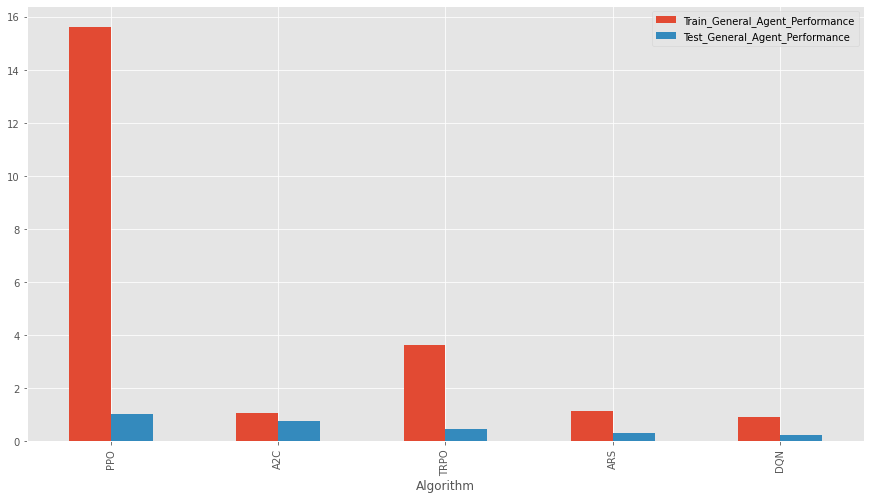

In [ ]:
overall_algorithm_performance_df[["Train_General_Agent_Performance","Test_General_Agent_Performance"]].\
                                sort_values(by="Test_General_Agent_Performance",ascending=False).plot.bar(figsize=(15,8))
plt.show()

Figure 9 Train Vs Test performance among the chosen algorithms.

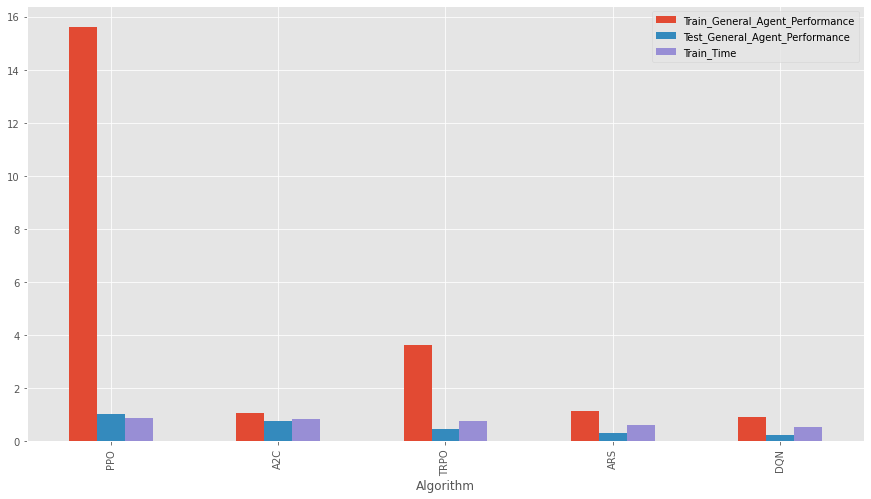

In [ ]:
overall_algorithm_performance_df[["Train_General_Agent_Performance","Test_General_Agent_Performance", "Train_Time"]].\
                                sort_values(by="Test_General_Agent_Performance",ascending=False).plot.bar(figsize=(15,8))
plt.show()

Figure 10 Training and test performance and training time of the chosen algorithms.

Figure[10] summarizes the outcome of task 8; as shown, the most generalized algorithm is PPO, and it also has the best training performance. However, the gap between the training and test performance is huge. Regarding the training time, PPO and A2C took approximately the same training time.

Note: We trained all models in this task on 10K timesteps because of: 

*   Training time will take a huge amount of time if we stick with 75K timesteps and we don't have enough GPU time on Kaggle (Collab is even worst). 
*   Regardless, our comparison is still fair and comparable since we used the same number of timesteps to train all the models.